# ALMA ephemeris object cube imaging (mosaic) using TRACKFIELD

## Description

The following demo describes cube imaging of ALMA observation of Comet Giacobini-Zinner. 
For imaigng of the sources that move significantly during the observations, proper ephemeris data need to be used. For the current ALMA data, the epehemeris tables used to track the source during the observation generally included in the ASDM. The task, importasdm attaches the ephemeris table(s) in FIELD sub-table in the generated MS. Here we starts from such MS data and also uses a short cut option called 'TRACKFIELD' in tclean to use the attached ephemeris table(s).

## Data

The dataset used here consists of the two MSes from Band 7 observations separated by 6 days using ACA. Each MS has an ephemeris table approriated for the observation attached. The data is available at /home/casa/data/casatestdata-large.

## Installation

### Option 1

### Option 2 - install at runtime

### Import libraries

In [2]:
from casatasks import getephemtable, tclean, exportfits, listobs, imstat, imhead
from casatools import measures, quanta, table, image
import os
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pylab as pl
import numpy as np
import aplpy
me = measures()
qa = quanta()
tb = table()
ia = image()

#### Import utility functions defined in a separate notebook

In [3]:
# import helper functions defined in EphemerisObjectImagingDemoFunctions.ipynb, which need to be
# present in the directory running the jupyter notebook/jupyter-lab

# requires ipynb 
from ipynb.fs.defs.EphemerisObjectImagingDemoFunctions import *

## Imaging with epehemeris data attached to the MS

In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available. In tclean, the phasecenter parameter can be set to point to the ephemeris table, which can be one attached to the MS (inside FIELD sub-table directory) or an external one. In this demo, we use a shortcut option, 'TRACKFIELD' to use the internal ephemeris table without explicitly specified by ephemeris table name. The spectral frame is set to 'cubesource', which a frame of the source. Note that the frame in the resultant image will be labelled as 'REST'. 


In [11]:
datapath='/home/casa/data/casatestdata-large/stakeholder/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/stakeholder/alma/'

In [12]:
msfile=[datapath+'2017.1.00750.T_tclean_exe1.ms',datapath+'2017.1.00750.T_tclean_exe2.ms']

In [13]:
imgname='21PGZComet-cubesrc-mosaic-trackfield'

In [9]:
delete_tcleanimages(imgname)
#delete_tcleanimages(img2name)

In [10]:
#os.system(f'cp -r {datapath}{msfile} {msfile}')

In [11]:
ret=tclean(vis=msfile, field='21PGiacobini-Zinner', spw=['0', '0'], \
            antenna=['0,1,2,3,4,5,6,7,8,9,10,11', '0,1,2,3,4,5,6,7,8,9'], \
            scan=['7,11,15,19,23', '8,12,16,20,24'], \
            intent='OBSERVE_TARGET#ON_SOURCE', datacolumn='data', \
            imagename=imgname, imsize=[80, 80], cell=['0.66arcsec'], \
            phasecenter='TRACKFIELD', stokes='I', specmode='cubesource', \
            nchan=1000, start='354.4452721710GHz', width='0.1221004MHz', perchanweightdensity=True, \
            gridder='mosaic', mosweight=False, \
            usepointing=True, pblimit=0.2, deconvolver='hogbom', \
            restoration=True, restoringbeam='common', pbcor=True, \
            #weighting='briggsbwtaper', robust=0.5, npixels=0, niter=30000, \
            weighting='briggsbwtaper', robust=0.5, npixels=0, niter=100, \
            threshold='0.274Jy', nsigma=0.0, usemask='auto'
            '-multithresh', sidelobethreshold=1.25, noisethreshold=5.0, \
            lownoisethreshold=2.0, negativethreshold=0.0, \
            minbeamfrac=0.1, growiterations=75, dogrowprune=True, \
            minpercentchange=1.0, fastnoise=False, restart=True, \
            calcres=True, calcpsf=True, savemodel='none', \
            parallel=False, verbose=True)
ret['iterdone']


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


339

### Examination of the resultant image
For displaying the resultant image, first find a peak channel and dispay that channel image.

In [52]:
# Find a peak channel
imstatres = imstat(imgname+'.image')
maxchan = imstatres['maxpos'][3]
print(maxchan)

488


In [15]:
# extract the channel image
#from casatasks import imsubimage
#os.system(f'rm -rf {imgname}ch{maxchan}.image')
#imsubimage(imagename=imgname+'.image', outfile=f'{imgname}ch{maxchan}.image', chans=f'{maxchan}')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<Figure size 2000x1000 with 0 Axes>

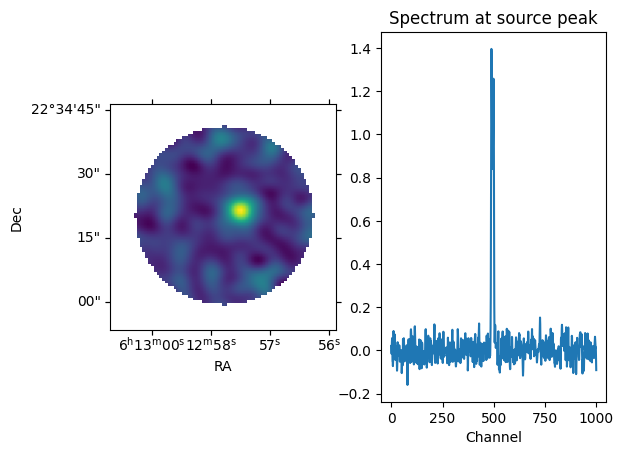

In [16]:
dispImage(f'{imgname}.image',chanslice=maxchan, useAstropy=True)

In [14]:
obsdate = imhead(f'{imgname}.image', mode='list')['date-obs']
print(obsdate)

2018/09/16/10:15:58.895999


In [15]:
ephemtab = get_attachedEphemtablepath(msfile[0],'21PGiacobini-Zinner')
ineph_dir = ephem_dir(ephemtab, obsdate,'ALMA')

In [182]:
print("Internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9)[0],qa.angle(ineph_dir['m1'],prec=9)[0])
print('Image center:',printImageCenter(imgname+'.image'))

Internal ephem dir =  06:12:57.770 +022.34.20.236
Image center: ('06:12:57.770', '+022.34.20.236')


 ### Spectral information

Determine image channel frequency at the peak 

In [49]:
ia.open(f'{imgname}.image')
csys = ia.coordsys()
csysrec = csys.torecord()
ia.done()
restfreq = csysrec['spectral2']['restfreq']
print('restfreq:',restfreq)

restfreq: 354505473000.0


In [50]:
# find image frequency at the peak
specaxis=csys.findcoordinate('spectral')['pixel'][0]
pixel=csys.referencepixel()

In [68]:
pixel['numeric'][specaxis] = maxchan
print(pixel)
f_peak = csys.toworld(pixel)['numeric'][specaxis]
# this is different from what I read from the Viewer
print(f_peak,'Hz')

{'ar_type': 'absolute', 'numeric': array([ 40.,  40.,   0., 488.]), 'pw_type': 'pixel'}
354504857166.2119 Hz


The spectrum is centered around the rest freqeuncy. This roughly indicates that the 'SOURCE' 
frame trasformation is done correctly. 
Now, from the radial velocity provided in the ephemeris table, check if the frequency shift is done correctly,.

In [27]:
# reference time in mjd
mjd0=qa.quantity(obsdate,'d')['value']
print(mjd0)

58377.427764999986


In [28]:
# Access ephemeris table data
tb.open(ephemtab)
mjdcol = tb.getcol('MJD')
radc = tb.getcol('RA')
decdc = tb.getcol('DEC')
rhoc = tb.getcol('Rho')
radvel=tb.getcol('RadVel')
tb.done()

True

In [184]:
# Do linear interpolation to get the radial velocity at the reference time
radv = np.interp(mjd0,mjdcol,radvel)
qradv = qa.convert(qa.quantity(radv,'AU/d'),'km/s')
raval = np.interp(mjd0,mjdcol,radc)
decval= np.interp(mjd0,mjdcol,decdc)
rhoval = np.interp(mjd0,mjdcol,rhoc)
print(qradv)
print(qa.time(qa.quantity(raval,'deg'),prec=9),qa.angle(qa.quantity(decval,'deg'),prec=9))

{'unit': 'km/s', 'value': 3.35206559623668}
['06:12:57.610'] ['+022.34.25.174']


In [112]:
vradkmps = qradv['value']

Run imaging with outfrmae = TOPO to compare the frequency at the peak

In [44]:
img2name = '21PGZComet-cube-topo-mosaic-trackfield'

In [87]:
ret=tclean(vis=msfile, field='21PGiacobini-Zinner', spw='0', \
            antenna='0,1,2,3,4,5,6,7,8,9,10,11', \
            scan='7,11,15,19,23', \
            intent='OBSERVE_TARGET#ON_SOURCE', datacolumn='data', \
            imagename=img2name, imsize=[80, 80], cell=['0.66arcsec'], \
            phasecenter='TRACKFIELD', stokes='I', specmode='cube', \
            nchan=1000, start='354.4452721710GHz', width='0.1221004MHz', perchanweightdensity=True, outframe='TOPO',\
            gridder='mosaic', mosweight=False, \
            usepointing=True, pblimit=0.2, deconvolver='hogbom', \
            restoration=True, restoringbeam='common', pbcor=True, \
            #weighting='briggsbwtaper', robust=0.5, npixels=0, niter=30000, \
            weighting='briggsbwtaper', robust=0.5, npixels=0, niter=100, \
            threshold='0.274Jy', nsigma=0.0, usemask='auto'
            '-multithresh', sidelobethreshold=1.25, noisethreshold=5.0, \
            lownoisethreshold=2.0, negativethreshold=0.0, \
            minbeamfrac=0.1, growiterations=75, dogrowprune=True, \
            minpercentchange=1.0, fastnoise=False, restart=True, \
            calcres=True, calcpsf=True, savemodel='none', \
            parallel=False, verbose=True)
ret['iterdone']


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


422

In [45]:
imstatres = imstat(img2name+'.image')
maxchantopo = imstatres['maxpos'][3]
print (f'maxchan in topo image:{maxchantopo}')

maxchan in topo image:457


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<Figure size 2000x1000 with 0 Axes>

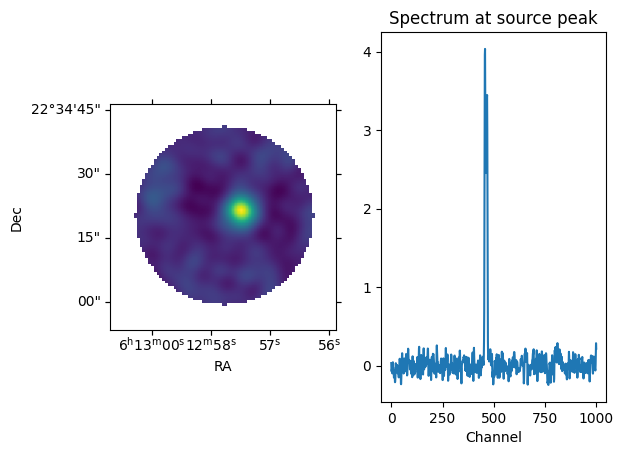

In [105]:
dispImage(f'{img2name}.image',chanslice=maxchantopo, useAstropy=True)

In [113]:
# Find a peak channel frequency in the TOPO image
ia.open(f'{img2name}.image')
csys = ia.coordsys()
ia.done()
pixel=csys.referencepixel()
pixel['numeric'][specaxis] = maxchantopo
print(pixel)
ftopo_peak = csys.toworld(pixel)['numeric'][specaxis]
# this is different from what I read from the Viewer
print(ftopo_peak,'Hz')

{'ar_type': 'absolute', 'numeric': array([ 40.,  40.,   0., 457.]), 'pw_type': 'pixel'}
354501072053.81116 Hz


In [114]:
# geocetric radial velocity of the observatory
me.doframe(me.observatory('ALMA'))
me.doframe(me.epoch(str(mjd0)+'d'))
vobsgeo = me.measure(me.radialvelocity('TOPO', '0.0m/s'),'GEO')
print(vobsgeo)

{'m0': {'unit': 'm/s', 'value': 1.1280218379322402}, 'refer': 'GEO', 'type': 'radialvelocity'}


In [187]:
# Add the source and observatory velocities. Note for the source's velocity flip the vector so it
# point back to the source
totvel=-1.*vradkmps*1000. + vobsgeo['m0']['value']
# expected shift in freq
#v/c = (f0**2 - f**2)/(f0**2 + f**2)
velperc = totvel/qa.constants('C')['value']
foverf0 = np.sqrt((1-velperc)/(1+velperc))
exp_fpeak = ftopo_peak*foverf0
print(f' expected frequency at peak shifting the topo peak frequency ({ftopo_peak}) = {exp_fpeak}')
print(f' actual peak frequency in cubesrc image = {f_peak}')
print("f_peak - exp_fpeak = ",f_peak - exp_fpeak)
# note that channel width is ~122kHz

 expected frequency at peak shifting the topo peak frequency (354501072053.81116) = 354505034520.4104
 actual peak frequency in cubesrc image = 354504857166.2119
f_peak - exp_fpeak =  -177354.19848632812


In [189]:
# The same excersise using measure tool
# imaging with TOPO
me.doframe(me.observatory('ALMA'))
me.doframe(me.epoch(str(mjd0)+'d'))
print("qvrad=",qradv)
modvrad = -1.*qradv['value'] + 1.1280218377914935/1000.
mradv = me.radialvelocity('GEO',str(modvrad)+'km/s')
dop=me.todoppler('radio', mradv)
print(f'vel={mradv}')
print(f'dop={dop}')
#mfrq = me.frequency('LSRK', qa.quantity(flsrk_peak,'Hz'))
mfrq = me.frequency('TOPO', qa.quantity(ftopo_peak,'Hz'))
print(f'mfrq={mfrq}')
# use 'REST' frame to convert frequency to that of SOURCE frame
exp_f_peak = me.tofrequency('REST', dop, me.frequency('REST', qa.quantity(ftopo_peak,'Hz')))
#print('expected frequecy at the peak in rest(source) frame using LSRK peak frequency:',exp_f_peak)
print('expected frequecy at the peak in lsrk frame using cubesrc peak frequency:',exp_f_peak)
print(f'compared to freq_peak from the cubesrc image = {f_peak} Hz')
print(f_peak - exp_f_peak['m0']['value'])

qvrad= {'unit': 'km/s', 'value': 3.35206559623668}
vel={'m0': {'unit': 'm/s', 'value': -3350.9375743988885}, 'refer': 'GEO', 'type': 'radialvelocity'}
dop={'m0': {'unit': 'm/s', 'value': -3350.9563022008015}, 'refer': 'RADIO', 'type': 'doppler'}
mfrq={'m0': {'unit': 'Hz', 'value': 354501072053.81116}, 'refer': 'TOPO', 'type': 'frequency'}
expected frequecy at the peak in lsrk frame using cubesrc peak frequency: {'m0': {'unit': 'Hz', 'value': 354505034520.4104}, 'refer': 'REST', 'type': 'frequency'}
compared to freq_peak from the cubesrc image = 354504857166.2119 Hz
-177354.19848632812


In [65]:
print('diff = ',f_peak-exp_f_peak['m0']['value'])
print('chan width : ',0.1221004*10**6)

diff =  -615839.7006225586
chan width :  122100.4


### Attempt to do the check with astropy....

In [77]:
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord
from astropy.time import Time

In [137]:
# find the radial velocity in BARY
mvrad_bary=me.measure(mradv,'BARY')
print(mvrad_bary)

{'m0': {'unit': 'm/s', 'value': 3167.1347751957956}, 'refer': 'BARY', 'type': 'radialvelocity'}


In [78]:
almaloc = EarthLocation.of_site('ALMA')
alma = almaloc.get_itrs(obstime=Time(casadatetoastropydate(obsdate)))
print(alma)

<ITRS Coordinate (obstime=2018-09-16T10:15:58.896, location=(0., 0., 0.) km): (x, y, z) in m
    (2225015.30883296, -5440016.41799762, -2481631.27428014)>


In [174]:
# velocity of the observatory
comet = SkyCoord(ra=raval * u.deg, dec=decval * u.deg, radial_velocity=mvrad_bary['m0']['value'] * u.m/ u.s, distance = rhoval * u.AU, frame='icrs')
print(obs.radial_velocity)

3167.1347751957956 km / s


In [175]:
freq_topo = ftopo_peak

In [176]:
sc_comet=SpectralCoord(freq_topo * u.GHz, observer = alma, target=comet)
print(sc_comet)
print(sc_comet.observer)
print(sc_comet.target)

354501072053.81116 GHz
<ITRS Coordinate (obstime=2018-09-16T10:15:58.896, location=(0., 0., 0.) km): (x, y, z) in m
    (2225015.30883296, -5440016.41799762, -2481631.27428014)
 (v_x, v_y, v_z) in km / s
    (0., 0., 0.)>
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, AU)
    (93.24003967, 22.5736594, 0.39746107)
 (radial_velocity) in m / s
    (3167.1347752,)>


In [177]:
retgcrs=sc_comet.with_observer_stationary_relative_to('gcrs')
print(retgcrs.radial_velocity)

-8909.481420486665 m / s


In [178]:
reticrs=sc_comet.with_observer_stationary_relative_to('icrs')
print(reticrs.radial_velocity)

1558.4059059114545 m / s


In [179]:
retlsrk=sc_comet.with_observer_stationary_relative_to('lsrk')
print(retlsrk.radial_velocity)

-4091.981543667804 m / s


In [180]:
ret=sc_comet.with_observer_stationary_relative_to(sc_comet.target)
print(ret.radial_velocity)
print(f'freq={ret.value/10**9} (actual {f_peak/10**9})')

-1.8694966592805056e-13 m / s
freq=354.49005681120764 (actual 354.50485716621193)


In [181]:
print(f'diff in freq (freq - actual ) : {ret.value - f_peak}')

diff in freq (freq - actual ) : -14800355.004272461
